# 1.0 Case Study: constructing a network of wikipedia pages

## 1.1 Introduction

So far we have learned two ways of constructing a complex network:
- from a CSV file
- manually

What is hard for small networks may be impossible for medium-to-large scale networks; it may be impossible even for small networks if you must repeat the analysis many
times. The case study in this lesson shows you **how to construct a large
network in an easy way**:
- automatically collecting node and edge data from the Internet.

The other goal of this study (aside from mastering new network construction
techniques) is quite pragmatic.
- Wouldn’t you want to know where the **complex
network analysis** fits in the context of other subjects and disciplines?

An answer to this question is near at hand: [on Wikipedia](https://en.wikipedia.org/wiki/Complex_network).


Let’s start with the Wikipedia page about complex networks—the seed page.
(Unfortunately, there is no page on complex network analysis itself.) The page
body has external links and links to other Wikipedia pages. Those other pages
presumably are somewhat related to complex networks, or else why would
the Wikipedia editors provide them?
To build a network out of the seed page and other relevant pages, **let’s treat
the pages (and the respective Wikipedia subjects) as the network nodes and
the links between the pages as the network edges**. You will use snowball
sampling (a breadth-first search or [BFS algorithm](https://en.wikipedia.org/wiki/Breadth-first_search)) to discover all the nodes and edges of interest.

<img width="200" src="https://drive.google.com/uc?export=view&id=1iC-cieOaZKy80adviVISLmM-2Zm7NL-i">

As a result, you will have a network of all pages related to complex networks
and hopefully, you will make some conclusions about it.

## 1.2 Get the Data, Build the Network

The first half of the project script consists of:

1. the initialization prologue
2. a heavy-duty loop that retrieves the Wikipedia pages and simultaneously builds the network of nodes and edges.

Let’s first import all necessary modules. We will need:

- the module **wikipedia** for fetching and exploring Wikipedia pages
- the operator **itemgetter** for sorting a list of tuples
- and, naturally, **networkx** itself.

To target the **snowballing process**, define the constant **SEED, the name of the
starting page**.

> As a side note, by changing the name of the seed page, you can
apply this analysis to any other subject on Wikipedia.


Last but not least, when you start the snowballing, you will eventually (and
quite soon) bump into the pages describing ISBN and ISSN numbers, the
arXiv, PubMed, and the like. Almost all other Wikipedia pages refer to one or
more of those pages. This hyper-connectedness transforms any network into
a collection of almost perfect gigantic stars, making all Wikipedia-based networks
look similar. **To avoid the stardom syndrome**, treat the known “star”
pages as stop words in information retrieval—in other words, ignore any links
to them.

Constructing the **black list of stop words**, STOPS, is a matter of trial
and error. We put thirteen subjects on it; you may want to add more when you
come across other “stars.” We also excluded pages whose names begin with
**"List of"**, because they are simply lists of other subjects.

In [1]:
!pip install wikipedia


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\rapha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt

In [3]:
nx.__version__

'3.1'

In [4]:
#https://en.wikipedia.org/wiki/Complex_network
SEED = "Mud logging".title()
STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier",
         "Pubmed Central",
         "Digital Object Identifier",
         "Arxiv",
         "Proc Natl Acad Sci Usa",
         "Bibcode",
         "Library Of Congress Control Number",
         "Jstor",
         "Doi (Identifier)",
         "Isbn (Identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)")

The next code fragment deals with setting up the **snowballing process**. A
breadth-first search, or BFS (sometimes known to computer programmers
as a snowballing algorithm), must remember which **pages have been already
processed** and which have been **discovered but not yet processed**.
- the former are stored in the set **done_set**;
- the latter, in the list **todo_lst** and **todo_set**.

You need two data structures for the unprocessed pages because you want to
know whether a page has been already recorded (an unordered lookup, *todo_set*) and
which page is the next to be processed (an ordered lookup, *todo_lst*).


Snowballing an extensive network—and Wikipedia with 6,578,766 articles in
the English segment alone can produce a huge network!—takes considerable
time.


<img width="300" src="https://drive.google.com/uc?export=view&id=1HS_M2Y55UD0PH_-8waDupAkgeDzSPBfG">


Suppose you start with one seed node, and let’s say it has $N\approx 100$ neighbors.
Each of them has $N$ neighbors, too, to the total of $\approx N+N×N$ nodes. The
third round of discovery adds $\approx N×N×N$ more nodes. The time to shave each
next layer of nodes grows exponentially. For this exercise, let’s process only
the seed node itself and its immediate neighbors (layers 0 and 1). Processing
layer 2 is still feasible, but layer 3 requires $N×N×N×N\approx 10^8$ page downloads. To keep track of the distance from the currently processed node to the seed, store both the layer to which a node belongs and the node name together as a tuple on the **todo_lst** list.

In [5]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0
todo_set = set(SEED) # The SEED itself
done_set = set() # Nothing is done yet

**The output of the exercise is a NetworkX graph**. The next fragment will create
an empty directed graph that will later absorb discovered nodes and edges.

> We choose a **directed graph** because the edges that represent HTML links
are naturally directed: a link from page A to page B does not imply a reciprocal
link.

The same fragment primes the algorithm by extracting the first “to-do” item
(both its layer and page name) from the namesake list.



In [6]:
g = nx.DiGraph()
layer, page = todo_lst[0]

It may take a fraction of a second to execute the first five lines of the script.
It may take the whole next year or longer to finish the next twenty lines
because they contain the main collection/construction loop of the project.

In [7]:
%%time
while layer < 2:
  # Remove the name page of the current page from the todo_lst,
  # and add it to the set of processed pages.
  # If the script encounters this page again, it will skip over it.
  del todo_lst[0]
  done_set.add(page)

  # Show progress
  print(layer, page)

  # Attempt to download the selected page.
  try:
    wiki = wikipedia.page(page)
  except:
    print("Could not load", page)
    layer, page = todo_lst[0]
    continue

  for link in wiki.links:
    link = link.title()
    if link not in STOPS and not link.startswith("List Of"):
      if link not in todo_set and link not in done_set:
        todo_lst.append((layer + 1, link))
        todo_set.add(link)
      g.add_edge(page, link)
  layer, page = todo_lst[0]

0 Mud Logging
1 Butane
1 Caliper Log
1 Chloride
1 Density Logging
1 Directional Drilling
1 Drill Cuttings
1 Drill Ship
1 Drill String
1 Drilling Fluid
1 Drilling Mud
1 Drilling Rig
1 Ethane


C:\Users\rapha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\rapha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Could not load Ethane
1 Formation (Stratigraphy)
1 Gamma Ray Logging
1 Gas Detector
1 Geologist
1 Geosteering
1 Hydrocarbon
1 Hydrocarbon Exploration
1 Hydrocarbons
1 Lime (Material)
1 Lithology
1 Logging While Drilling
1 Louisiana
1 Mwd (Measurement While Drilling)
1 Measurement While Drilling
1 Mud Engineer
1 Mud Log
1 Mud Weight
1 Natural Gas
1 Nuclear Magnetic Resonance Logging
1 Offshore Drilling Rig
1 Oil Well
1 Petroleum
1 Pore Space In Soil
1 Porosity
1 Propane
1 Rate Of Penetration
1 Resistivity Logging
1 Revolutions Per Minute
Could not load Revolutions Per Minute
1 Sand
Could not load Sand
1 Shale
1 Sieves
1 Sonic Logging
1 Spontaneous Potential Logging
1 Tool Pusher
1 Viscosity
1 Well Logging
CPU times: total: 2.92 s
Wall time: 2min 22s


In [8]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

8720 nodes, 12740 edges


The network of interest is now in the variable g. But it is “dirty”: inaccurate, incomplete, and erroneous.

## 1.3 Eliminate Duplicates

Many Wikipedia pages exist under two or more names. For example, there
are pages about **Complex Network** and **Complex Networks**. The latter redirects
to the former, but NetworkX does not know about the redirection.

Accurately merging all duplicate nodes involves **natural language processing
(NLP) tools that are outside of the scope of this course**. It may suffice to join
only those nodes that differ by the presence/absence of the letter s at the end
or a hyphen in the middle.

Start removing self-loops (pages referring to themselves). The loops don’t change
the network properties but affect the correctness of duplicate node elimination.
Now, you need a list of at least some duplicate nodes. You can build it by
looking at each node in g and checking if a node with the same name, but
with an s at the end, is also in g.

Pass each pair of duplicated node names to the function **nx.contracted_nodes(g,u,v)** that merges node v into node u in the graph g. The function reassigns all edges previously incident to v, to u. If you don’t pass the option **self_loops=False**, the function converts an edge from v to u (if any) to a self-loop.

In [9]:
# make a copy of raw graph
original = g.copy()

In [10]:
# remove self loops
g.remove_edges_from(nx.selfloop_edges(g))

# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s")
              for node in g if node + "s" in g
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(g, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in
              [(node, node.replace("-", " ")) for node in g]
                if x != y and y in g]
print(duplicates)

for dup in duplicates:
  g = nx.contracted_nodes(g, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(g, 0,"contraction")
nx.set_edge_attributes(g, 0,"contraction")

[('Hydrocarbon', 'Hydrocarbons'), ('Shale', 'Shales'), ('Alkane', 'Alkanes'), ('Alkene', 'Alkenes'), ('Borane', 'Boranes'), ('Cycloalkane', 'Cycloalkanes'), ('Diphosphene', 'Diphosphenes'), ('Gallane', 'Gallanes'), ('Germane', 'Germanes'), ('Plumbane', 'Plumbanes'), ('Silane', 'Silanes'), ('Stannane', 'Stannanes'), ('Structural Isomer', 'Structural Isomers'), ('Borehole', 'Boreholes'), ('Drill Bit', 'Drill Bits'), ('Clay Mineral', 'Clay Minerals'), ('Deviation Survey', 'Deviation Surveys'), ('Oil Field', 'Oil Fields'), ('Oil Shale', 'Oil Shales'), ('Water Well', 'Water Wells'), ('Fertilizer', 'Fertilizers'), ('Landfill', 'Landfills'), ('Microorganism', 'Microorganisms'), ('Plant', 'Plants'), ('Barge', 'Barges'), ('Semi-Submersible', 'Semi-Submersibles'), ('Glycol', 'Glycols'), ('Shale Shaker', 'Shale Shakers'), ('Feldspar', 'Feldspars'), ('Sandstone', 'Sandstones'), ('Gas Leak', 'Gas Leaks'), ('Refrigerant', 'Refrigerants'), ('Semiconductor', 'Semiconductors'), ('Ultrasonic Sensor', 'U

In [11]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

8661 nodes, 12291 edges


## 1.4 Truncate the network

Why did you go through all those Wikipedia troubles? First, to construct a
network of subjects related to complex networks—and here it is. Second, to
find other significant topics related to complex networks. **But what is the
measure of significance?**


You will discover a variety of network measures latter in this course. For now, let’s concentrate on a **node indegree**—the number of edges directed into the node. (In the same spirit, the number of edges directed out of the node is called **outdegree**.) The indegree of a node equals the number of HTML links pointing to the respective page. **If a page has a lot of links to it, the topic of the page must be significant.**


The extracted graph
has 13,526 nodes and 24,724 edges—an average of 1.82 edges per node. **Most
of the nodes have only one connection**. (Interestingly, there are no isolated
nodes with no connection in the graph. Even if they exist, you will not find
them because of the way snowballing works.) **You can remove all nodes with
only one incident edge to make the network more compact and less hairy
without hurting the final results**.

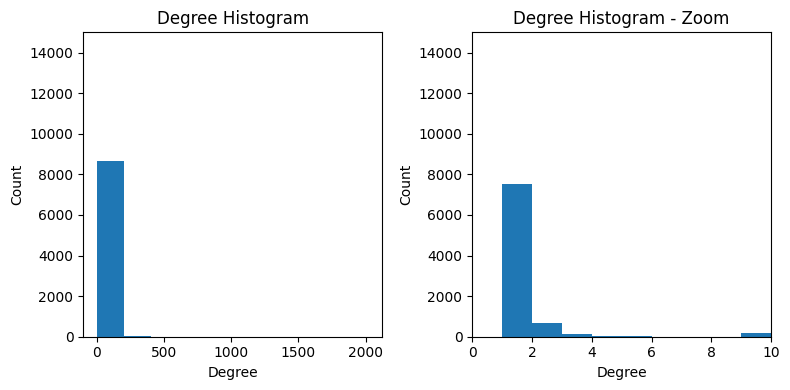

In [12]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,15000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,15000)

plt.tight_layout()
plt.show()

In [13]:
# filter nodes with degree greater than or equal to 2
core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

# select a subgraph with 'core' nodes
gsub = nx.subgraph(g, core)

print("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

nx.write_graphml(gsub, "cna.graphml")

1128 nodes, 4758 edges


In [14]:
print("Nodes removed: {:.2f}%".format(100*(1 - 3420/13775)))
print("Edges removed: {:.2f}%".format(100*(1 - 14771/24856)))
print("Edges per nodes: {:.2f}".format(13775/3420))

Nodes removed: 75.17%
Edges removed: 40.57%
Edges per nodes: 4.03


As you can see, the following code fragment safely removes 75 percent of the
nodes and 40 percent of the edges, raising the average number of edges per
node to 4.03.

## 1.5 Explore the network

The following figure is a [Gephi](https://gephi.org/) rendering of **gsub**. Node
and label font sizes represent the indegrees (a filter was added in gephi just to show only node with indegree greater than 50). The most in-connected, most significant
nodes are in the upper-left corner of the network. What are they?

<img width="600" src="https://drive.google.com/uc?export=view&id=1voCZAh8-8YPKuekNHbc_h45MLgM6Rfg6">


The last code fragment of the exercise efficiently calculates the answer by
calling the method **gsub.in_degree()**. The method (and its sister method **gsub.out_degree()**)
are very similar to **gsub.degree()** except that they report different edge counts in the form of objects InDegreeView and OutDegreeView, respectively.

In [15]:
top_indegree = sorted(dict(gsub.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:100]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))

19 Drilling Fluid
19 Measurement-While-Drilling
19 Well Logging
17 Logging While Drilling
16 Hydrocarbon
16 Petroleum
14 Hydrocarbon Exploration
14 Oil Well
13 Borehole
13 Mud Logging
13 Directional Drilling
13 Drilling Rig
13 Issn (Identifier)
12 Gulf Of Mexico
12 Caliper Log
12 Transocean
12 S2Cid (Identifier)
12 Petrophysics
12 Core Sample
12 Resistivity Logging
12 Gamma Ray Logging
12 Geosteering
12 Density Logging
12 Nuclear Magnetic Resonance Logging
12 Sonic Logging
12 Petroleum Industry
12 Spontaneous Potential Logging
12 Natural Gas
11 Exxonmobil
11 Halliburton
11 Exploration Geophysics
11 Oil Refinery
11 Weatherford International
11 Baker Hughes
11 Occidental Petroleum
11 Petroleum Geology
11 Chevron Corporation
11 Drilling Engineering
11 Türkiye Petrolleri Anonim Ortaklığı
11 Valaris Limited
11 North Sea Oil
11 Reliance Industries
11 Blowout (Well Drilling)
11 Bp
11 Pipeline Transport
11 Water Injection (Oil Production)
11 Drilling Fluid Invasion
11 Drill Stem Test
11 Eni
11

**Further Studies**


- This section presented a complete complex network construction case study,
starting from the raw data in the form of HTML pages, all the way to an analyzable
annotated network graph and a simple exploratory exercise. This is
a good foundation for more systematic complex network studies. Now is your turn, choice a topic of your interest and reproduce yourself a complet complex network case study.

- Some examples (not limited to):

  - https://en.wikipedia.org/wiki/Black_Lives_Matter
  - https://en.wikipedia.org/wiki/COVID-19
  - https://en.wikipedia.org/wiki/Harry_Potter
  - https://en.wikipedia.org/wiki/Sherlock_Holmes
  - https://en.wikipedia.org/wiki/Augusto_Severo_de_Albuquerque_Maranh%C3%A3o
  - https://en.wikipedia.org/wiki/Brazil
  - https://en.wikipedia.org/wiki/Bitcoin
  - https://en.wikipedia.org/wiki/Federal_University_of_Rio_Grande_do_Norte
  - https://en.wikipedia.org/wiki/Petrobras
  - https://en.wikipedia.org/wiki/List_of_presidents_of_Brazil
- Explore some metrics studied in Unit 02 to highlight insights in your analysis.

In [ ]:
# put your results here

